<a href="https://colab.research.google.com/github/BiancaStadl/Bachelorarbeit/blob/main/03_huggingface_German_Bert_API_drei_Inputs_ohne_Freeze.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://towardsdatascience.com/working-with-hugging-face-transformers-and-tf-2-0-89bf35e3555a


Following is a general pipeline for any transformer model:
Tokenizer definition →Tokenization of Documents →Model Definition →Model Training →Inference

https://colab.research.google.com/github/huggingface/notebooks/blob/master/transformers_doc/training.ipynb

https://huggingface.co/transformers/ (get started)

Sehr wichtig: https://huggingface.co/transformers/notebooks.html

Citation: Using GPU in colab and Tensorflow: https://colab.research.google.com/notebooks/gpu.ipynb#scrollTo=Y04m-jvKRDsJ

In [2]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [3]:
%tensorflow_version 2.x
import tensorflow as tf
import timeit

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print(
      '\n\nThis error most likely means that this notebook is not '
      'configured to use a GPU.  Change this in Notebook Settings via the '
      'command palette (cmd/ctrl-shift-P) or the Edit menu.\n\n')
  raise SystemError('GPU device not found')

def cpu():
  with tf.device('/cpu:0'):
    random_image_cpu = tf.random.normal((100, 100, 100, 3))
    net_cpu = tf.keras.layers.Conv2D(32, 7)(random_image_cpu)
    return tf.math.reduce_sum(net_cpu)

def gpu():
  with tf.device('/device:GPU:0'):
    random_image_gpu = tf.random.normal((100, 100, 100, 3))
    net_gpu = tf.keras.layers.Conv2D(32, 7)(random_image_gpu)
    return tf.math.reduce_sum(net_gpu)
  
# We run each op once to warm up; see: https://stackoverflow.com/a/45067900
cpu()
gpu()

# Run the op several times.
print('Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images '
      '(batch x height x width x channel). Sum of ten runs.')
print('CPU (s):')
cpu_time = timeit.timeit('cpu()', number=10, setup="from __main__ import cpu")
print(cpu_time)
print('GPU (s):')
gpu_time = timeit.timeit('gpu()', number=10, setup="from __main__ import gpu")
print(gpu_time)
print('GPU speedup over CPU: {}x'.format(int(cpu_time/gpu_time)))

Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images (batch x height x width x channel). Sum of ten runs.
CPU (s):
3.663276378999967
GPU (s):
0.04902659300000778
GPU speedup over CPU: 74x


In [4]:

import os
import re
import shutil
import string
import tensorflow as tf
import numpy as np
from keras import losses
from tensorflow import keras 
from keras import optimizers 
from keras import metrics 

from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import preprocessing


https://huggingface.co/bert-base-german-cased

mit folgenden Paramter (laut doku)

batch_size = 1024
n_steps = 810_000
max_seq_len = 128 (and 512 later)
learning_rate = 1e-4
lr_schedule = LinearWarmup
num_warmup_steps = 10_000


In [5]:
max_length = 60

In [6]:
#Next step is now to perform tokenization on documents. It can be performed either by encode() or encode_plus() method.
#https://towardsdatascience.com/working-with-hugging-face-transformers-and-tf-2-0-89bf35e3555a
#alles original von ihm.
def tokenize(sentences, tokenizer):
    input_ids, input_masks, input_segments = [],[],[]
    #for sentence in tqdm(sentences):
    for sentence in sentences:
        inputs = tokenizer.encode_plus(sentence, add_special_tokens=True, max_length=60, pad_to_max_length=True, truncation=True,
                                             return_attention_mask=True, return_token_type_ids=True)
        input_ids.append(inputs['input_ids'])
        input_masks.append(inputs['attention_mask'])
        input_segments.append(inputs['token_type_ids'])        
        
    return np.asarray(input_ids, dtype='int32'), np.asarray(input_masks, dtype='int32'), np.asarray(input_segments, dtype='int32')

In [7]:
!pip install transformers

     |████████████████████████████████| 3.4 MB 5.3 MB/s 
     |████████████████████████████████| 61 kB 489 kB/s 
     |████████████████████████████████| 596 kB 53.0 MB/s 
     |████████████████████████████████| 3.3 MB 40.1 MB/s 
     |████████████████████████████████| 895 kB 47.7 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [8]:
#2.3.3 Fine-tuning a Pretrained transformer model, noch immer von https://towardsdatascience.com/working-with-hugging-face-transformers-and-tf-2-0-89bf35e3555a

from transformers import AutoTokenizer, TFAutoModelForMaskedLM, AutoConfig, AutoModelForMaskedLM
#Ich hab mi AutoModelForMaskedLM einen Fehler bekommen; Lösung war hier: https://stackoverflow.com/questions/67274470/attributeerror-kerastensor-object-has-no-attribute-size-with-hugging-face-be
german_bert='bert-base-german-cased'
#german_bert='distilbert-base-german-cased'

  # Defining German bert tokenizer
tokenizer = AutoTokenizer.from_pretrained(german_bert, max_length=60, pad_to_max_length=True,add_special_tokens=True)

#do_lower_case=True, add_special_tokens=True?
#add_special_tokens: Is used to add special character like <cls>, <sep>,<unk>, etc w.r.t Pretrained model in use. It should be always kept True

#https://huggingface.co/transformers/model_doc/auto.html#autoconfig
# Download configuration from huggingface.co and cache.
# Change some config attributes when loading a pretrained config.
config = AutoConfig.from_pretrained('bert-base-german-cased', dropout=0.2, attention_dropout=0.2, num_labels=2)

#config = GermanBertConfig(dropout=0.2, attention_dropout=0.2)
config.output_hidden_states = False

German_model = TFAutoModelForMaskedLM.from_pretrained(german_bert, config=config)

input_ids_in = tf.keras.layers.Input(shape=(60,), name='input_token', dtype='int32')
input_attmasks_in = tf.keras.layers.Input(shape=(60,), name='attention_token', dtype='int32') 
token_type_ids_in = tf.keras.layers.Input(shape=(60,),name="token_type_ids", dtype='int32')

embedding_layer = German_model(input_ids=input_ids_in, attention_mask=input_attmasks_in, token_type_ids=token_type_ids_in)[0]
X = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(160, return_sequences=True, dropout=0.3))(embedding_layer)
X = tf.keras.layers.GlobalMaxPool1D()(X)
X = tf.keras.layers.Dense(90, activation='relu')(X)
X = tf.keras.layers.Dropout(0.2)(X)
X = tf.keras.layers.Dense(1, activation='sigmoid')(X)
modell = tf.keras.Model(inputs=[input_ids_in, input_attmasks_in,token_type_ids_in], outputs = X)

##original -> 
# embedding_layer = German_model(input_ids_in, attention_mask=input_attmasks_in)[0]
# X = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(50, return_sequences=True, dropout=0.1, recurrent_dropout=0.1))(embedding_layer)
# X = tf.keras.layers.GlobalMaxPool1D()(X)
# X = tf.keras.layers.Dense(120, activation='relu')(X)
# X = tf.keras.layers.Dropout(0.2)(X)
# X = tf.keras.layers.Dense(1, activation='sigmoid')(X)
# model = tf.keras.Model(inputs=[input_ids_in, input_attmasks_in], outputs = X)

# for layer in model.layers[:4]:
#   layer.trainable = True


Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/433 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/249k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/474k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/508M [00:00<?, ?B/s]

All model checkpoint layers were used when initializing TFBertForMaskedLM.

All the layers of TFBertForMaskedLM were initialized from the model checkpoint at bert-base-german-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForMaskedLM for predictions without further training.


In [9]:
modell.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_token (InputLayer)       [(None, 60)]         0           []                               
                                                                                                  
 attention_token (InputLayer)   [(None, 60)]         0           []                               
                                                                                                  
 token_type_ids (InputLayer)    [(None, 60)]         0           []                               
                                                                                                  
 tf_bert_for_masked_lm (TFBertF  TFMaskedLMOutput(lo  109112880  ['input_token[0][0]',            
 orMaskedLM)                    ss=None, logits=(No               'attention_token[0][0]',    

In [10]:
import keras.backend as K

def metrics_recall(data_true, data_pred):
    true_positives = K.sum(K.round(K.clip(data_true*data_pred,0,1)))
    possible_positives = K.sum(K.round(K.clip(data_true,0,1)))

    recall = true_positives / (possible_positives+K.epsilon())
    return recall


def metrics_precision(data_true, data_pred):
    true_positives = K.sum(K.round(K.clip(data_true*data_pred,0,1)))

    positives_predicted = K.sum(K.round(K.clip(data_pred,0,1)))
    precision = true_positives / (positives_predicted+K.epsilon())
    return precision


def metrics_f1(data_true, data_pred):
    precision_data = metrics_precision(data_true, data_pred)
    recall_data = metrics_recall(data_true, data_pred)
    return 2*(precision_data*recall_data)/(precision_data+recall_data+K.epsilon())

In [11]:
url = "https://github.com/uds-lsv/GermEval-2018-Data/archive/master.zip"

dataset = tf.keras.utils.get_file("GermEval-2018-Data-master.zip", url, 
                                   extract=True, cache_dir='.',
                                    cache_subdir='')

dataset_dir = os.path.join(os.path.dirname(dataset), 'GermEval-2018-Data-master')


13697024/Unknown - 1s 0us/step

In [12]:
#os.listdir(dataset_dir)

In [13]:
training_file = os.path.join(dataset_dir, 'germeval2018.training.txt')
#with open(training_file) as f:
 # print(f.read())

#print()

testing_file = os.path.join(dataset_dir, 'germeval2018.test.txt')


In [14]:
def remove_clutter(string):
   string = re.sub("@[^\s]+"," ",string)
   string = re.sub("#[^\s]+"," ", string)
   string = re.sub("\u00a9"," ", string)
   string = re.sub("\u00ae"," ", string)
   string = re.sub("[\u2000-\u3300]"," ", string)
   string = re.sub("\ud83c[\ud000-\udfff]"," ", string)
   string = re.sub("\ud83d[\ud000-\udfff]"," ", string)
   string = re.sub("\ud83e[\ud000-\udfff]"," ", string)
   string = re.sub("😜", " ",string)
   string = re.sub("🍫", " ",string)
   string = re.sub("😁", " ",string)
   string = re.sub("🐖", " ",string)
   string = re.sub("😡", " ",string)
   string = re.sub("😇", " ",string)
   string = re.sub("😬", " ",string)
   string = re.sub("😃", " ",string)
   string = re.sub("😂", " ",string)
   string = re.sub("💙", " ",string)  
   string = re.sub("😛", " ",string)
   string = re.sub("🙏", " ",string)
   string = re.sub("👍", " ",string)
   string = re.sub("🖕", " ",string)
   string = re.sub("😉", " ",string)
   string = re.sub("💩", " ",string)
   string = re.sub("🤢", " ",string)
   string = re.sub("👏", " ",string)
   string = re.sub("😨", " ",string)
   string = re.sub("🤣", " ",string)
   string = re.sub("🤡", " ",string)
   string = re.sub("😈", " ",string)
   string = re.sub("💃🏽", " ",string)
   string = re.sub("👹", " ",string)
   string = re.sub("🤘", " ",string)
   string = re.sub("😱", " ",string)
   string = re.sub("🤔", " ",string) 
   string = re.sub("🌈", " ",string) 
   string = re.sub("💕", " ",string) 
   string = re.sub("👩‍❤️‍👩", " ",string) 
   string = re.sub("😍", " ",string) 
   string = re.sub("👆", " ",string) 
   string = re.sub("😖", " ",string) 
   string = re.sub("👇", " ",string) 
   string = re.sub("🔥", " ",string) 
   string = re.sub("😘", " ",string) 
   string = re.sub("🎉", " ",string) 
   string = re.sub("🤬", " ",string) 
   string = re.sub("👊", " ",string)
   string = re.sub("🇩🇪", " ",string)  
   string = re.sub("💔", " ",string)
   string = re.sub("🙈", " ",string)
   string = re.sub("🤯", " ",string)
   string = re.sub("🐟", " ",string)
   string = re.sub("🛶", " ",string)
   string = re.sub("😊", " ",string)
   string = re.sub("😓", " ",string)
   string = re.sub("😳", " ",string)
   string = re.sub("🚀", " ",string)
   string = re.sub("👎", " ",string)
   string = re.sub("😎", " ",string)
   string = re.sub("🐸", " ",string)
   string = re.sub("📈", " ",string)
   string = re.sub("🙂", " ",string)
   string = re.sub("😅", " ",string)
   string = re.sub("😆", " ",string)
   string = re.sub("🙎🏿", " ",string)
   string = re.sub("👎🏽", " ",string)
   string = re.sub("🤭", " ",string)
   string = re.sub("😤", " ",string)
   string = re.sub("😚", " ",string)
   string = re.sub("😊", " ",string)
   string = re.sub("😲", " ",string)
   string = re.sub("🤮", " ",string)
   string = re.sub("🙄", " ",string)
   string = re.sub("🤑", " ",string)
   string = re.sub("🎅", " ",string)
   string = re.sub("👋", " ",string)
   string = re.sub("💪", " ",string)
   string = re.sub("😄", " ",string)
   string = re.sub("🧐", " ",string)
   string = re.sub("😠", " ",string)
   string = re.sub("🎈", " ",string)
   string = re.sub("🚂", " ",string)
   string = re.sub("😊", " ",string)
   string = re.sub("🚇", " ",string)
   string = re.sub("🚊", " ",string)
   string = re.sub("🤷", " ",string)
   string = re.sub("😥", " ",string)
   string = re.sub("🙃", " ",string)
   string = re.sub("🔩", " ",string)
   string = re.sub("🔧", " ",string)
   string = re.sub("🔨", " ",string)
   string = re.sub("🛠", " ",string)
   string = re.sub("💓", " ",string)
   string = re.sub("💡", " ",string)
   string = re.sub("🍸", " ",string)
   string = re.sub("🥃", " ",string)
   string = re.sub("🥂", " ",string)
   string = re.sub("😷", " ",string)
   string = re.sub("🤐", " ",string)
   string = re.sub("🌎", " ",string)
   string = re.sub("👑", " ",string)
   string = re.sub("🤛", " ",string)
   string = re.sub("😀", " ",string)
   string = re.sub("🛤", " ",string)
   string = re.sub("🎄", " ",string)
   string = re.sub("📴", " ",string)
   string = re.sub("🌭", " ",string)
   string = re.sub("🤕", " ",string)
   string = re.sub("😭", " ",string)
   string = re.sub("🍾", " ",string)
   string = re.sub("🍞", " ",string)
   string = re.sub("🤦", " ",string)
   string = re.sub("🤯", " ",string)
   string = re.sub("🕯️", " ",string)

   string = re.sub("OTHER|OFFENSE|ABUSE|INSULT"," ",string)
   return string

In [15]:
statementsForTraining = []
sentimentsForTraining = []

fileToRead = open(training_file, 'r')

while True:
  #next line in file
  line = fileToRead.readline()

  if line == "":
   break

  findSentiment = re.search("OTHER|OFFENSE",line)

  line = remove_clutter(line)
      

  statementsForTraining.append(line)

  if findSentiment.group(0) == "OTHER":  
    sentimentsForTraining.append(0)
  else:
    sentimentsForTraining.append(1)

  if not line:
    break

 #print("{}: {}".format(count,line.strip()))
  
 # print(sentiment.group(0))
 
fileToRead.close()

training_sentences = statementsForTraining
training_labels = sentimentsForTraining

#print(training_sentences[0:100])
#print(training_labels[9])  

In [16]:

statementsForTesting = []
sentimentsForTesting = []

fileToRead = open(testing_file, 'r')

while True:
 
  line = fileToRead.readline()

  if line == "":
   break

  sent = re.search("OTHER|OFFENSE",line)

  line = remove_clutter(line)


  statementsForTesting.append(line)
  #print(len(line))

  if sent.group(0) == "OTHER": 
    sentimentsForTesting.append(0)
  else:
    sentimentsForTesting.append(1)

  if not line:
    break


fileToRead.close()


testing_sentences = statementsForTesting
testing_labels = sentimentsForTesting
#print(len(testing_sentences))
#print(testing_sentences)   
#print(statementsForTesting)

In [17]:
!pip install -q tf-models-official
from official.nlp import optimization

     |████████████████████████████████| 1.8 MB 5.3 MB/s 
     |████████████████████████████████| 90 kB 9.6 MB/s 
     |████████████████████████████████| 99 kB 9.7 MB/s 
     |████████████████████████████████| 4.9 MB 35.8 MB/s 
     |████████████████████████████████| 352 kB 47.6 MB/s 
     |████████████████████████████████| 1.1 MB 51.2 MB/s 
     |████████████████████████████████| 1.2 MB 47.3 MB/s 
     |████████████████████████████████| 43 kB 2.1 MB/s 
     |████████████████████████████████| 213 kB 51.9 MB/s 
     |████████████████████████████████| 47.7 MB 63 kB/s 


[Linktext](https://stackoverflow.com/questions/38340311/what-is-the-difference-between-steps-and-epochs-in-tensorflow)
What is train steps?
Step: A training step means using one batch size of training data to train the model. Number of training steps per epoch: total_number_of_training_examples / batch_size . Total number of training steps: number_of_epochs x Number of training steps per epoch .

In [18]:
training_epochs = 3

#das ist dann schon wieder von 01 (tf tutorial classify text)

steps_per_epoch = 157
num_train_steps = steps_per_epoch * training_epochs
num_warmup_steps = int(0.1*num_train_steps)
#num_warmup_steps = 10_000 int(0.1*num_train_steps)

init_lr = 3e-5
#init_lr=2e-5
#laut German bert docu:
#init_lr =1e-4 
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

INFO:absl:using Adamw optimizer
INFO:absl:gradient_clip_norm=1.000000


In [19]:
loss = tf.keras.losses.BinaryCrossentropy()
metrics = tf.metrics.BinaryAccuracy()

In [20]:
modell.compile(loss=loss, optimizer=optimizer ,metrics=[metrics,metrics_recall,metrics_precision,metrics_f1])

In [21]:
# Encode training set X
X_train_ids, X_train_attention, X_segments = tokenize(training_sentences,tokenizer)

# Encode test set
Y_test_ids, Y_test_attention, Y_segments = tokenize(testing_sentences,tokenizer)
#encding von https://towardsdatascience.com/hugging-face-transformers-fine-tuning-distilbert-for-binary-classification-tasks-490f1d192379

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2232: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


steps-per-epoch-Erklärung...
https://stackoverflow.com/questions/49922252/choosing-number-of-steps-per-epoch
Traditionally, the steps per epoch is calculated as train_length // batch_size, since this will use all of the data points, one batch size worth at a time.

In [22]:
modell.fit(
    x = [X_train_ids, X_train_attention, X_segments],
    y=np.array(training_labels),
    epochs = 3,
    batch_size = 32
    #validation_data = ([Y_test_ids, Y_test_attention],testing_labels.to_numpy())
)

Epoch 1/3
157/157 [==============================] - 239s 1s/step - loss: 0.5414 - binary_accuracy: 0.7241 - metrics_recall: 0.4719 - metrics_precision: 0.5756 - metrics_f1: 0.4816
Epoch 2/3
157/157 [==============================] - 212s 1s/step - loss: 0.3549 - binary_accuracy: 0.8467 - metrics_recall: 0.7440 - metrics_precision: 0.7961 - metrics_f1: 0.7573
Epoch 3/3
157/157 [==============================] - 212s 1s/step - loss: 0.2232 - binary_accuracy: 0.9160 - metrics_recall: 0.8543 - metrics_precision: 0.8888 - metrics_f1: 0.8643


prediction und so kann dann eigentlich auch von hier https://colab.research.google.com/drive/18GKh0XbdDS8YBlIur1E2yfIFZGcaL1dC#scrollTo=YjfBDQO4y7vV
 verwendet werden, sollte funktionieren

https://deeplizard.com/learn/video/km7pxKy4UHU

Quelle der def plot_confusion_matrix: https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py 

In [23]:
BERTGermanPredict = modell.predict([Y_test_ids, Y_test_attention, Y_segments])
BERT_pred_thresh = np.where(BERTGermanPredict >= 0.5, 1, 0)

In [24]:
BERT_pred_thresh

array([[0],
       [0],
       [0],
       ...,
       [1],
       [0],
       [0]])

In [25]:
BERTGermanPredict

array([[0.02928371],
       [0.06340361],
       [0.0566313 ],
       ...,
       [0.9741411 ],
       [0.02037731],
       [0.0393191 ]], dtype=float32)

In [26]:
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt

In [27]:
def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [28]:
cm = confusion_matrix(y_true=testing_labels, y_pred=BERT_pred_thresh)

In [29]:
plot_labels = ['no hatespeech','hatespeech']

Confusion matrix, without normalization
[[2140  190]
 [ 514  688]]


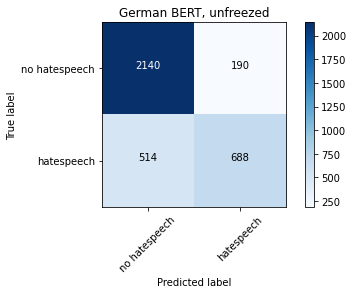

In [30]:
plot_confusion_matrix(cm=cm, classes=plot_labels, title='German BERT, unfreezed')

In [31]:
from sklearn.metrics import accuracy_score

In [32]:
accuracy = accuracy_score(testing_labels, BERT_pred_thresh)

In [33]:
accuracy

0.8006795016987542